**Livrable** : Un ou des notebooks (ou des fichiers .py) contenant les fonctions permettant le prétraitement et la feature extraction des données textes et images ainsi que les résultats de l’étude de faisabilité (graphiques, mesure de similarité) 

In [2]:
%%capture
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md
!python -m spacy download en_core_web_trf

In [3]:
import os
import pandas as pd
import numpy as np

In [4]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

# Lecture du jeu de données flipkart

In [5]:
# Read the content of the flipkart.csv file
flipkart = pd.read_csv('pj1_flipkart.csv', encoding='utf-8', encoding_errors='replace', parse_dates=['crawl_timestamp'])

In [6]:
# Print the information of the flipkart DataFrame
print(flipkart.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   uniq_id                  1050 non-null   object             
 1   crawl_timestamp          1050 non-null   datetime64[ns, UTC]
 2   product_url              1050 non-null   object             
 3   product_name             1050 non-null   object             
 4   product_category_tree    1050 non-null   object             
 5   pid                      1050 non-null   object             
 6   retail_price             1049 non-null   float64            
 7   discounted_price         1049 non-null   float64            
 8   image                    1050 non-null   object             
 9   is_FK_Advantage_product  1050 non-null   bool               
 10  description              1050 non-null   object             
 11  product_rating           1050 

# Commentaires sur le fichier flipkart après visualisation sur le data wrangler

| Champs                    | Description                                                                                  | Utile |
|---------------------------|----------------------------------------------------------------------------------------------|-------|
| uniq_id                   | Nom des fichiers images dans le répertoire image                                             | O     |
| crawl_timestamp           | Timestamp du crawler qui a récupéré les images                                               | N     |
| product_url               | Lien URL contenant le product_name & le PID                          | N     |
| product_name              | Nom du produit extrait de l'URL                                                             | O     |
| product_category_tree     | Fil d'ariane à extraire de la catégorie de produit categorical                               | O     |
| pid                       | Product ou Page ID                                                                                   | N     |
| retail_price              | Prix                                                                                         | O     |
| discounted_price          | Prix réduit                                                                                  | O     |
| image                     | La même chose que uniq_id mais avec le format à la fin                                       | O     |
| is_FK_Advantage_product   | Série booléenne de ?                                                                         | N     |
| description               | Description string du produit                                                                | O     |
| product_rating            | Note moyenne, attention les valeurs nulles sont remplacées par 'No rating available'         | O     |
| overall_rating            | Semble identique                                                                             | N     |
| brand                     | La marque, contient beaucoup de valeurs manquantes, peut être récupéré du product name       | N     |
| product_specifications    | Sous forme de K-V pair sur les key feature du produit                                        | O     |


# Vérification sur les champs

En plus du fichier flipkart, nous avons un répertoire contenant les images des produits. <br>
**Nous allons vérifier si les images dans le répertoire correspondent aux images dans le fichier flipkart** pour pouvoir ensuite rapprocher le dataset avec les images.

In [7]:
# Count the number of files in the current directory
print("Nombre de fichiers dans le répertoire Images: ", len(os.listdir("./Images")))

# Check if the number of lines in the flipkart.csv file is equal to the number of files in the Images directory
assert (
    len(os.listdir("./Images")) == len(flipkart)
), "Le nombre de lignes ne corresponds pas au nombre de fichiers dans le repertoire Images"

# Check if the uniq_id column has the same names than the files in the Images directory
files_without_jpg = [file.strip(".jpg") for file in os.listdir("./Images")]
assert (
    flipkart["uniq_id"].isin(files_without_jpg).all()
), "Les fichiers dans le repertoire Images ne correspondent pas aux fichiers dans le fichier flipkart.csv"
print("La colonne uniq_id contient les mêmes noms que les fichiers dans le répertoire Images")


Nombre de fichiers dans le répertoire Images:  1050
La colonne uniq_id contient les mêmes noms que les fichiers dans le répertoire Images


In [8]:
# Check if the image column is equal to the uniq_id column with the .jpg extension
assert flipkart["uniq_id"].equals(
    flipkart["image"].str.strip(".jpg")
), "les colonnes image sans l'extension .jpg et uniq_id ne correspondent pas"
print("La colonne image est égale à la colonne uniq_id sans l'extension .jpg")


La colonne image est égale à la colonne uniq_id sans l'extension .jpg


In [9]:
# Check if the image column contains different image formats
print("Les formats d'images sont:")
flipkart['image'].str.rsplit('.', expand=True)[1].value_counts()

Les formats d'images sont:


1
jpg    1050
Name: count, dtype: int64

In [10]:
# Check if the product_rating column is equal to the overall_rating column
assert flipkart["product_rating"].equals(
    flipkart["overall_rating"]
), "les colonnes product_rating et overall_rating ne correspondent pas"
print("La colonne product_rating est égale à la colonne overall_rating")


La colonne product_rating est égale à la colonne overall_rating


# Extraction des catégories de produits

**Nous allons extraire les catégories de produits pour pouvoir les utiliser dans la classification des produits.**<br>
Chaque catégorie est séparée par un '>>' et nous allons les séparer et les stocker dans une colonne 'category_1', 'category_2', 'category_3' etc...<br>
La colonne 'category_1' contient la catégorie principale, 'category_2' la sous-catégorie et 'category_3' la sous-sous-catégorie, etc...

In [11]:
# Extract the categories from the product_category_tree column into separate columns
categories = (
    flipkart["product_category_tree"].str.strip('["|"]')
    .str.split(">>", expand=True)
    .rename(columns={i: f'category_{i}' for i in range(0, 7)})
    )

# Concatenate the flipkart and categories dataframes and drop the product_category_tree column
flipkart_with_cat = (
    pd.concat([flipkart, categories], axis=1)
    .drop("product_category_tree", axis=1)
)

# Sélection des colonnes utiles

**Pour la suite de l'analyse, on va sélectionner les colonnes utiles pour la classification des produits.**<br>
On travaillera sur les colonnes 'product_name', 'description' et 'product_specifications' pour les données textes et sur les colonnes 'image' pour les données images.<br>
Concernant la colonne 'product_specifications', il est encore difficile de savoir si l'on va l'utiliser pour la classification des produits. Nous allons donc la conserver pour le moment.

In [12]:
fields = [
    "uniq_id",
    "product_name",
    "category_0",
    "category_1",
    "category_2",
    "category_3",
    "category_4",
    "category_5",
    "category_6",
    "retail_price",
    "discounted_price",
    "description",
    "product_rating",
    "product_specifications"
]

J'appellerai le nouveau dataframe `flipkart_filtered` qui contiendra les colonnes utiles pour la classification des produits.	

In [13]:
# Create a new DataFrame with the selected fields
flipkart_filtered = flipkart_with_cat[fields].copy()

# Remplacement des ratings nuls

In [14]:
# Replace the text "No rating available" by 0 in the product_rating column and convert it to float
flipkart_filtered = flipkart_filtered.assign(**{'product_rating': lambda x: x['product_rating'].replace('No rating available', np.nan).astype(float)})

# Identification des erreurs d'encodage dans les colonnes textes

J'ai identifié un problème d'encodage dans les colonnes textuelles avec le caractère �.<br>
Regardons les colonnes textuelles pour vérifier la présence de ce caractère.

In [15]:
# Define the problematic pattern
pattern = "�"

# Check if the flipkart_filtered DataFrame contains the character �
flipkart_filtered.select_dtypes(include='object').apply(lambda x: x.str.count(pattern).sum())

uniq_id                    0.0
product_name               3.0
category_0                 0.0
category_1                 0.0
category_2                 0.0
category_3                 0.0
category_4                 1.0
category_5                 0.0
category_6                 0.0
description               11.0
product_specifications     4.0
dtype: float64

In [16]:
# Create a new list
words = []
non_words = []

# Create a pattern to match words containing the character � with a pattern like "___" which doesn't exist in the text
word_pattern = r"\b\w*___\w*\b"
nonword_pattern = r"\b\W*___\W*\b"

# Add each word with word_pattern to the words list and each word with nonword_pattern to the non_words list
for column in flipkart_filtered.select_dtypes(include='object').replace('�', '___'):
    words.append((column, flipkart_filtered[column].dropna().str.replace('�', '___').str.findall(word_pattern).sum()))
    non_words.append((column, flipkart_filtered[column].dropna().str.replace('�', '___').str.findall(nonword_pattern).sum()))

# Print the words and non_words lists
print(words)
print(non_words)

[('uniq_id', []), ('product_name', ['Repouss______', '___']), ('category_0', []), ('category_1', []), ('category_2', []), ('category_3', []), ('category_4', ['___']), ('category_5', []), ('category_6', []), ('description', ['Repouss______', 'Repouss______', '___To', '___', '___To', '___', '___', 'd___cor', 'd___cor']), ('product_specifications', ['Repouss______', 'Repouss______'])]
[('uniq_id', []), ('product_name', [' ___ ']), ('category_0', []), ('category_1', []), ('category_2', []), ('category_3', []), ('category_4', [' ___ ']), ('category_5', []), ('category_6', []), ('description', ['.___\r\n', '.___', ' ___ ']), ('product_specifications', [])]


Après inspection des passages concernée, je peux remplacer les passages spécifiques avec "Repouss��" et "d�cor" par "Repousse" et "decor" respectivement.<br>
Pour le reste, je vais supprimer les occurences de ce caractère.

In [17]:
# Define the pattern to match
pattern_1 = "Repouss��"
pattern_2 = "d�cor"

# Replace the pattern_1 by "Repoussé" and the pattern_2 by "décor" in the product_specifications column
for column in flipkart_filtered.select_dtypes(include='object'):
    flipkart_filtered[column] = flipkart_filtered[column].str.replace(pattern_1, "Repoussé").str.replace(pattern_2, "décor").str.replace(pattern, '')

# Check if the flipkart_filtered DataFrame contains the character �
assert flipkart_filtered.select_dtypes(include='object').apply(lambda x: x.str.count(pattern).sum()).sum() == 0.0, "Il reste encore des caractères � dans le DataFrame"

# EDA sur les colonnes


In [18]:
flipkart_filtered

,uniq_id,product_name,category_0,category_1,category_2,category_3,category_4,category_5,category_6,retail_price,discounted_price,description,product_rating,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,None,None,None,1899.0,899.0,Key Features of Elegance Polyester Multicolor ...,NaN,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",None,None,600.0,449.0,Specifications of Sathiyas Cotton Bath Towel (...,NaN,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,None,None,NaN,NaN,Key Features of Eurospa Cotton Terry Face Towe...,NaN,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,None,None,2699.0,1299.0,Key Features of SANTOSH ROYAL FASHION Cotton P...,NaN,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,None,None,2599.0,698.0,Key Features of Jaipur Print Cotton Floral Kin...,NaN,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,Oren Empower Extra Large Self Adhesive Sticker,Baby Care,Baby & Kids Gifts,Stickers,Oren Empower Stickers,None,None,None,1399.0,999.0,Oren Empower Extra Large Self Adhesive Sticker...,NaN,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,Wallmantra Large Vinyl Sticker Sticker,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,None,None,None,4930.0,1896.0,Wallmantra Large Vinyl Sticker Sticker (Pack o...,NaN,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Baby Care,Baby & Kids Gifts,Stickers,Uberlyfe Stickers,None,None,None,4500.0,1449.0,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,NaN,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,Wallmantra Medium Vinyl Sticker Sticker,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,None,None,None,3465.0,1333.0,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,NaN,"{""product_specification""=>[{""key""=>""Number of ..."


In [19]:
for i in range(1, 7):
    print("Number of categories in category_{}:".format(i))
    print(flipkart_filtered[f'category_{i}'].nunique())

Number of categories in category_1:
63
Number of categories in category_2:
246
Number of categories in category_3:
350
Number of categories in category_4:
297
Number of categories in category_5:
117
Number of categories in category_6:
57


In [20]:
# Concatenante the product_name and description columns
flipkart_filtered["text"] = flipkart_filtered["product_name"] + " " + flipkart_filtered["description"]

# CV - TF-IDF sur les colonnes textes

In [21]:
# Préparation des données textes pour encode avec CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Création d'une instance de TfIdfVectorizer
vectorizer = TfidfVectorizer()

In [22]:
# Encodage des données textes
X = vectorizer.fit_transform(flipkart_filtered["text"])

In [23]:
# Récupération du nom des features
feature_names = vectorizer.get_feature_names_out()

# Création d'un DataFrame avec les données encodées
text_encoded = pd.DataFrame(X.toarray(), columns=feature_names)

In [24]:
text_encoded

,00,000,001,0021,004,005,006,0083,01,011,...,zinc,zingalalaa,zip,zipexterior,zipper,zippered,zone,zoom,zora,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
text_encoded.sum(axis=0).sort_values(ascending=False)

of             39.887814
only           37.715187
for            35.120723
at             32.578276
and            31.970817
                 ...    
safely          0.028043
trip            0.028043
portability     0.028043
348             0.028043
notepad         0.028043
Length: 6052, dtype: float64

In [26]:
import spacy


In [27]:
# Load the English tokenizer
nlp = spacy.blank("en")

In [28]:
# Print the attributes of the spacy pipeline
print(nlp.pipe_names)

[]


In [29]:
# Load the English spacy Roberta model
nlp = spacy.load("en_core_web_trf")

In [30]:
# Print the attributes of the spacy pipeline
print(nlp.pipe_names)

['transformer', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [31]:
# Remove every attribute of the spacy pipeline except the lemmatizer
nlp.disable_pipes("transformer", "ner")


['transformer', 'ner']

In [32]:
nlp.pipe_names

['tagger', 'parser', 'attribute_ruler', 'lemmatizer']

In [33]:
def spacy_preprocessor(doc):
    return " ".join([token.text for token in nlp(doc) if not token.is_stop and token.is_alpha])

In [34]:
def spacy_preprocessor(doc):
    return " ".join([token.lemma_.lower() for token in nlp(doc) if not token.is_stop and token.is_alpha])

In [35]:
tfidf = TfidfVectorizer(preprocessor=spacy_preprocessor, min_df=5, strip_accents='unicode')

In [36]:
TfidfVectorizer?

Init signature:
TfidfVectorizer(
    *,
    input='content',
    encoding='utf-8',
    decode_error='strict',
    strip_accents=None,
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    analyzer='word',
    stop_words=None,
    token_pattern='(?u)\\b\\w\\w+\\b',
    ngram_range=(1, 1),
    max_df=1.0,
    min_df=1,
    max_features=None,
    vocabulary=None,
    binary=False,
    dtype=<class 'numpy.float64'>,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=False,
)
Docstring:     
Convert a collection of raw documents to a matrix of TF-IDF features.

Equivalent to :class:`CountVectorizer` followed by
:class:`TfidfTransformer`.

For an example of usage, see
:ref:`sphx_glr_auto_examples_text_plot_document_classification_20newsgroups.py`.

For an efficiency comparison of the different feature extractors, see
:ref:`sphx_glr_auto_examples_text_plot_hashing_vs_dict_vectorizer.py`.

For an example of document clustering and comparison with
:class:`~sklea

In [37]:
text = "he loves working with data. It works like a charm at his work"

In [38]:
doc = nlp(text)

In [39]:
for token in doc:
    print(token.text, token.lemma_, token.is_stop, token.is_alpha)

he he True True
loves loves False True
working working False True
with with True True
data data False True
. . False False
It it True True
works works False True
like like False True
a a True True
charm charm False True
at at True True
his his True True
work work False True


In [40]:
# Encodage des données textes
X = tfidf.fit_transform(flipkart_filtered["text"])

In [41]:
# Récupération du nom des features
feature_names = tfidf.get_feature_names_out()

# Création d'un DataFrame avec les données encodées
text_encoded = pd.DataFrame(X.toarray(), columns=feature_names)

In [42]:
text_encoded

,absorbent,abstract,ac,accessories,actual,adapter,adapters,add,addition,additional,...,wooden,work,working,works,world,wrap,year,years,yellow,yes
0,0.0,0.22267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.058079,0.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.170886,0.066963
2,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.052228,0.000000,0.000000
3,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.041370
4,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.034267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1046,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.114025,0.0,0.0,0.000000,0.000000,0.000000
1047,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1048,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [43]:
text_encoded.sum(axis=0).sort_values(ascending=False)

watch         51.714058
analog        46.032912
products      44.781049
cm            44.466399
free          44.449946
                ...    
requirment     0.232632
volatege       0.232632
assure         0.232632
deviation      0.232632
compliance     0.232632
Length: 933, dtype: float64

GENSIM

In [44]:
from gensim.models import Word2Vec

# Prétraitement des données avec spaCy
def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens



In [45]:
# Iterating over the ligne of text column and return the preprocessed text under token format
preprocessed_text = flipkart_filtered["text"].apply(preprocess)

In [46]:
# Entraînement du modèle Word2Vec avec gensim
model = Word2Vec(sentences=preprocessed_text, vector_size=100, window=5, min_count=1, workers=4)

# Accès aux embeddings
word_embeddings = model.wv

In [47]:
# Affichage du nombre de mots dans le vocabulaire
print("Nombre de mots dans le vocabulaire:", len(word_embeddings.key_to_index))

Nombre de mots dans le vocabulaire: 5291


**LLM Medium Cours**


* Les premiers modèles de langage
    * Ruled-based systems : Utilisation d'un mapping pour traduire des phrases
    * Statistical Machine Translation (SMT) : Utilisation d'un modèle d'alignement (constitué de plusieurs composants tels que langage input model/translation model/reordering model/inflection model/etc... pour chaque pair de langage) pour traduire des phrases (Google Translate 2006)
        * Gestion du positionnement des mots (ex. S-O-V vers S-V-O)
        * Gestion de l'omission des mots (ex. "I am looking for a job" vers "Je cherche un emploi")
        * Gestion de l'ajout de mots (ex. "J'irai" vers "I will go")
    * Early Neural Machine Translation (NMT) : Utilisation de réseaux de neurones (CNN/RNN) pour traduire des phrases de 2010 à 2014
    * Encoder-Decoder : Utilisation de deux réseaux de neurones (un pour encoder et un pour decoder) pour traduire des phrases de 2014 à 2016


In [48]:
doc = list(flipkart_filtered["text"].str.lower())

In [49]:
len(word_embeddings.key_to_index)

5291

In [50]:
word_embeddings.key_to_index

{'cm': 0,
 'products': 1,
 'free': 2,
 'rs': 3,
 'buy': 4,
 'replacement': 5,
 'delivery': 6,
 'genuine': 7,
 'shipping': 8,
 'cash': 9,
 'day': 10,
 'watch': 11,
 'guarantee': 12,
 'set': 13,
 'baby': 14,
 'mug': 15,
 'online': 16,
 'features': 17,
 'analog': 18,
 'price': 19,
 'cotton': 20,
 'color': 21,
 'pack': 22,
 'showpiece': 23,
 'material': 24,
 'type': 25,
 'box': 26,
 'ceramic': 27,
 'general': 28,
 'package': 29,
 'specifications': 30,
 'sales': 31,
 'men': 32,
 'number': 33,
 'laptop': 34,
 'design': 35,
 'warranty': 36,
 'quality': 37,
 'combo': 38,
 'details': 39,
 'usb': 40,
 'product': 41,
 'brand': 42,
 'best': 43,
 'model': 44,
 'girl': 45,
 'key': 46,
 'fabric': 47,
 'prices': 48,
 'women': 49,
 'india': 50,
 'great': 51,
 'multicolor': 52,
 'inch': 53,
 'perfect': 54,
 'skin': 55,
 'size': 56,
 'coffee': 57,
 'ideal': 58,
 'dimensions': 59,
 'home': 60,
 'printed': 61,
 'gift': 62,
 'black': 63,
 'blue': 64,
 'water': 65,
 'contents': 66,
 'x': 67,
 'battery': 68,


In [51]:
# Afficher les premiers mots et leurs embeddings
for word in list(word_embeddings.key_to_index)[:10]:
    print(word, word_embeddings[word])

cm [-0.4841393   0.51680154  0.14245746  0.717367    0.22378787 -0.58280104
  0.30336887  1.3318617  -0.8372995  -0.16694313 -0.52299505 -0.91827667
  0.13139142  0.0681693   0.05934478 -0.55106413 -0.252133   -1.0897369
  0.00932036 -0.7781129   0.5454306   0.5300761  -0.81853276  0.1891369
  0.05165251 -0.35398945 -0.5026403   0.02623173 -0.25630733 -0.95849353
  0.42651072  0.64712405  0.6493667  -0.8967496   0.31983155  0.7911122
  0.05848731 -0.6324286   0.6664067  -1.4626687  -0.36248222 -0.8357112
 -0.3380292  -0.2841681   0.34783724 -0.74547803 -1.4394455   0.30673054
  0.32958627  0.2838999   0.12762573  0.09401909  0.14668363  0.10814697
  0.36671752  0.78478664  0.10570814 -0.18111208 -0.50687224  0.9182405
 -0.32223427  0.51932746 -0.6956396  -0.48077226 -1.0353992  -0.04476128
  0.211921    0.5054501  -0.64127845  1.482992   -0.23950322 -0.00797816
  0.5615678  -0.70782846  1.0499065  -0.10597039  0.99356747 -0.4735581
 -0.21227875  0.37186956 -0.12329471 -0.11370645 -0.44

In [52]:
# Exemple d'utilisation des embeddings
word = 'watch'
if word in word_embeddings:
    print(f"Embedding for '{word}': {word_embeddings[word]}")

# Trouver les mots les plus similaires
similar_words = word_embeddings.most_similar('watch')
print(f"Words most similar to 'watch': {similar_words}")

Embedding for 'watch': [ 1.71242499e+00 -5.65243483e-01 -5.69020927e-01  7.74482861e-02
  9.59142208e-01 -7.43332684e-01  1.58293068e-01  2.55171013e+00
 -3.26863915e-01 -1.00097239e+00 -5.88399827e-01  6.92418098e-01
 -6.82156920e-01  6.47694349e-01  3.77506465e-01 -4.98117507e-02
 -1.12042689e+00 -6.86232686e-01  3.24619025e-01 -8.76472712e-01
  7.91150510e-01 -2.04151416e+00  4.81923401e-01 -4.73992229e-01
  7.07137048e-01 -2.08105111e+00  6.88531920e-02 -1.95483670e-01
  5.30568838e-01 -3.47866744e-01 -5.77816188e-01  3.07726085e-01
  6.58291340e-01 -1.08027494e+00  1.08927524e+00  2.57873893e-01
  1.09228469e-01 -2.99736738e-01 -2.92559683e-01 -2.32465172e+00
 -4.21798766e-01 -1.32183146e+00 -1.59441993e-01  1.89912581e+00
  9.43247437e-01 -1.19450903e+00 -2.87624985e-01  1.96874306e-01
  1.40330946e+00  1.41702783e+00  4.59236532e-01 -9.49374259e-01
  7.65224814e-01  1.75350472e-01 -2.03864306e-01  1.01070389e-01
 -1.91739842e-01 -6.27887607e-01 -6.81293726e-01  1.25096726e+00
 -

In [53]:
# compte le nombre de word embeddings
print(f"Number of word embeddings: {len(word_embeddings)}")

Number of word embeddings: 5291


In [54]:
# convertit les embeddings en array
type(word_embeddings.vectors)

numpy.ndarray

In [55]:
len(word_embeddings.vectors)

5291

In [56]:
# For each row in the flipkart_filtered text column, replace each word by its embedding and compute the mean of the embeddings
mean_embeddings = flipkart_filtered["text"].apply(lambda x: np.mean([word_embeddings[word] for word in x.split() if word in word_embeddings], axis=0))

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [57]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

In [58]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    # Détermination des clusters à partir des données avant Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(features)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

In [59]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct_alpha(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

In [60]:
l_cat = list(flipkart_filtered['category_0'].unique())
l_cat

['Home Furnishing ',
 'Baby Care ',
 'Watches ',
 'Home Decor & Festive Needs ',
 'Kitchen & Dining ',
 'Beauty and Personal Care ',
 'Computers ']

In [61]:
y_cat_num = [(1-l_cat.index(flipkart_filtered.loc[i, 'category_0'])) for i in range(len(flipkart_filtered))]

In [62]:
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(text_encoded)

Tf-idf : 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.2864 time :  12.0


In [63]:
# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des commentaires par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des commentaires par clusters')
    
    plt.show()
    print("ARI : ", ARI)

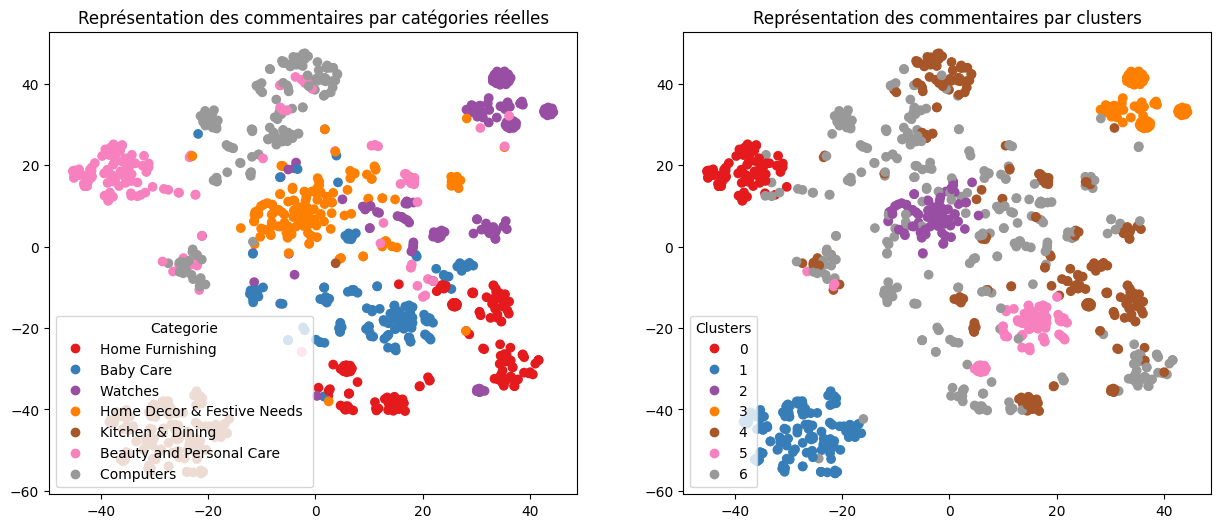

ARI :  0.2864


In [64]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [65]:
from umap import UMAP

In [66]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_umap_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(features)
    # Calcul de l'embedding Umap pour un BOW TF-IDF
    umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.3, metric='cosine', random_state=42)
    X_umap = umap.fit_transform(features)

    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_umap, cls.labels_

In [67]:
# visualisation du Tsne selon les vraies catégories et selon les clusters
def UMAP_visu_fct(X_umap, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_umap[:,0],X_umap[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des commentaires par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_umap[:,0],X_umap[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des commentaires par clusters')
    
    plt.show()
    print("ARI : ", ARI)

In [68]:
print("Tf-idf : ")
print("--------")
ARI, X_umap, labels = ARI_umap_fct(text_encoded)

Tf-idf : 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


ARI :  0.2864 time :  12.0


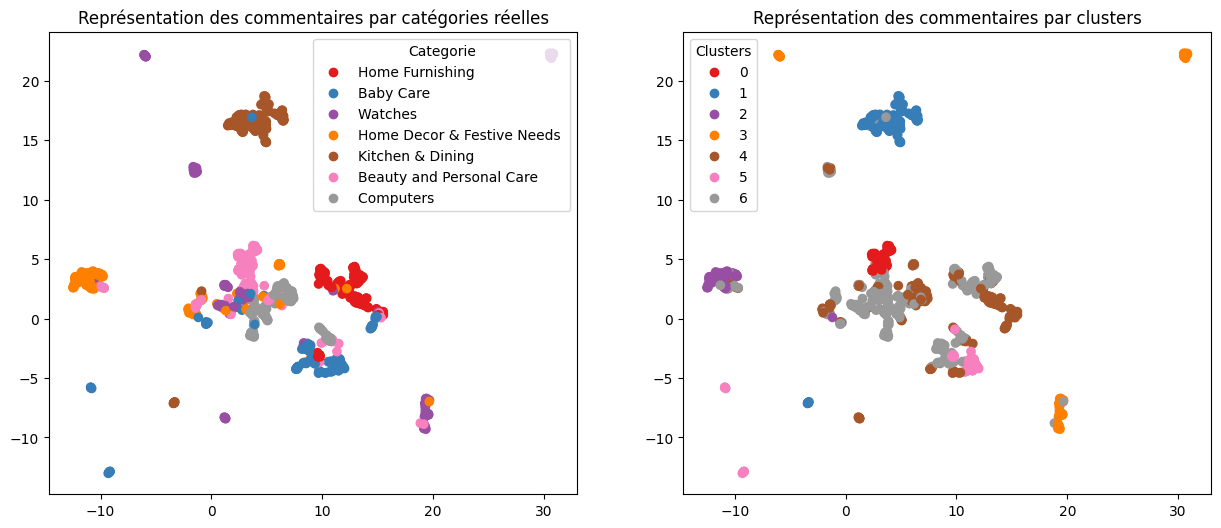

ARI :  0.2864


In [69]:
UMAP_visu_fct(X_umap, y_cat_num, labels, ARI)

In [70]:
mean_embeddings

0       [-0.047272496, 0.2132095, 0.052534964, 0.05900...
1       [-0.06384869, 0.21715464, -0.009281198, 0.1047...
2       [-0.044521853, 0.22325823, 0.028787933, 0.0659...
3       [-0.1813322, 0.2720377, 0.03567541, 0.2910174,...
4       [-0.10671515, 0.28863925, 0.041734636, 0.16638...
                              ...                        
1045    [-0.024826342, 0.1516768, 0.05104458, 0.020826...
1046    [-0.061505437, 0.2408852, 0.09776134, 0.025291...
1047    [-0.277587, 0.17678213, 0.35918787, -0.0155168...
1048    [-0.28102535, 0.18516734, 0.36205077, -0.01097...
1049    [-0.277587, 0.17678213, 0.35918787, -0.0155168...
Name: text, Length: 1050, dtype: object

In [71]:
mean_embeddings.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1050 entries, 0 to 1049
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
1049 non-null   object
dtypes: object(1)
memory usage: 8.3+ KB


In [72]:
# Compute the len of each list in each row of the mean_embeddings series
mean_embeddings[mean_embeddings.isna()]

286    NaN
Name: text, dtype: object

In [73]:
# Créer une liste de 100 zéros
zeros_list = [0] * 100

In [74]:
mean_embeddings.iloc[286] = zeros_list

In [75]:
mean_embeddings_list = mean_embeddings.tolist()

In [76]:
# unpack the test list into the DataFrame
mean_embeddings_df = pd.DataFrame(mean_embeddings_list, index=flipkart_filtered.index, columns=[f"embedding_{i}" for i in range(100)])
mean_embeddings_df

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
0,-0.047272,0.213209,0.052535,0.059001,0.097597,-0.185294,0.071006,0.492290,-0.153316,-0.056166,...,0.252520,0.075116,-0.201454,0.077348,0.247688,0.240195,0.058283,-0.104193,0.082070,-0.098203
1,-0.063849,0.217155,-0.009281,0.104730,0.104369,-0.140752,0.074759,0.412652,-0.113533,-0.007126,...,0.211530,0.004615,-0.130051,0.071162,0.105649,0.126689,-0.011001,-0.107876,0.058046,-0.054751
2,-0.044522,0.223258,0.028788,0.065975,0.103998,-0.172525,0.073538,0.485104,-0.135631,-0.040388,...,0.253735,0.060315,-0.193465,0.081550,0.221973,0.217331,0.029609,-0.107786,0.078262,-0.093579
3,-0.181332,0.272038,0.035675,0.291017,0.114762,-0.240631,0.137622,0.597831,-0.295909,-0.031487,...,0.224409,-0.064416,-0.025842,0.080791,0.034630,0.102493,-0.026295,-0.257948,0.130338,-0.016376
4,-0.106715,0.288639,0.041735,0.166381,0.122137,-0.229348,0.114245,0.627369,-0.223400,-0.035940,...,0.292793,0.023488,-0.164909,0.095169,0.202070,0.216999,0.014795,-0.187460,0.115848,-0.089498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-0.024826,0.151677,0.051045,0.020826,0.095854,-0.170240,0.052428,0.445524,-0.159326,-0.081559,...,0.228185,0.097022,-0.195639,0.072893,0.269277,0.238101,0.069813,-0.089851,0.081962,-0.108453
1046,-0.061505,0.240885,0.097761,0.025291,0.108143,-0.236307,0.085525,0.601802,-0.205844,-0.088296,...,0.318316,0.135152,-0.267830,0.087227,0.383883,0.343413,0.102841,-0.132906,0.114089,-0.149896
1047,-0.277587,0.176782,0.359188,-0.015517,0.117010,-0.447991,0.120477,0.878355,-0.720066,-0.438471,...,0.393043,0.365764,-0.296185,0.110634,0.806887,0.640153,0.422268,-0.310709,0.334167,-0.312023
1048,-0.281025,0.185167,0.362051,-0.010972,0.126018,-0.462520,0.124195,0.897024,-0.725324,-0.442854,...,0.404089,0.372462,-0.309278,0.113939,0.824837,0.656368,0.430177,-0.318225,0.335628,-0.317134


In [77]:
print("W2C: ")
print("--------")
ARI, X_tsne, labels = ARI_fct(mean_embeddings_df)

W2C: 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.1455 time :  10.0


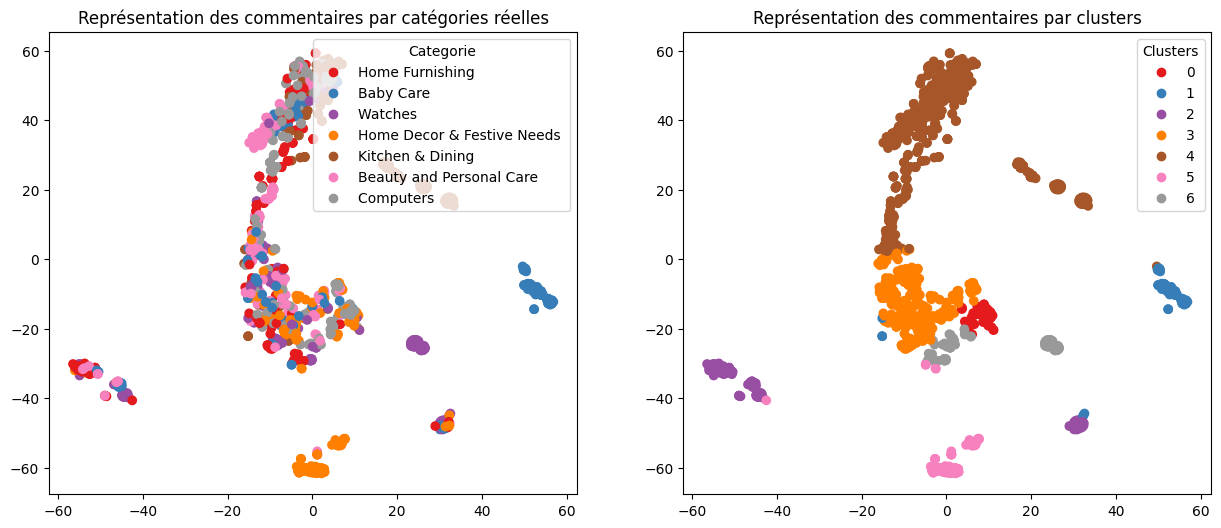

ARI :  0.1455


In [78]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# GLOVE

In [79]:
# Loading the vectors from the glove text file
def load_glove_vectors(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
    return words, word_to_vec_map


In [80]:
# Load the glove vectors 100d
words, word_to_vec_map = load_glove_vectors("./Glove/glove.6B.100d.txt")

In [81]:
# Print the number of words and the number of word vectors
print(f"Number of words: {len(words)}")
print(f"Number of word vectors: {len(word_to_vec_map)}")

Number of words: 400000
Number of word vectors: 400000


In [82]:
# replace each word by its word vectors and compute the mean of the word vectors
mean_glove_embeddings = flipkart_filtered["text"].apply(lambda x: np.mean([word_to_vec_map[word] for word in x.split() if word in word_to_vec_map], axis=0))

In [83]:
mean_glove_embeddings.head(5)

0    [-0.16213717887323947, 0.22297854014084514, 0....
1    [-0.22170421428571424, 0.2429507142857143, 0.0...
2    [-0.19085365263157905, 0.24833988421052644, 0....
3    [-0.4202625581395349, 0.45723334883720923, 0.0...
4    [-0.35139654545454546, 0.37244684000000017, 0....
Name: text, dtype: object

In [84]:
glove = pd.DataFrame(mean_glove_embeddings.tolist(), index=flipkart_filtered.index, columns=[f"glove_{i}" for i in range(100)])

In [85]:
print("GLOVE: ")
print("--------")
ARI, X_tsne, labels = ARI_fct(glove)

GLOVE: 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.2485 time :  10.0


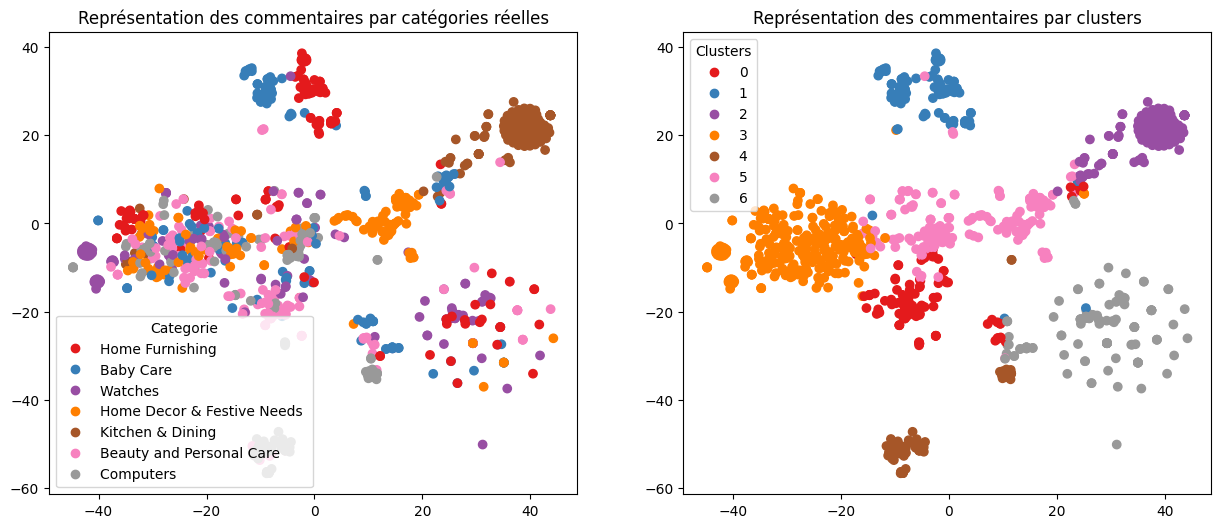

ARI :  0.2485


In [86]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [87]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers

os.environ["TF_KERAS"]='1'

In [88]:
# install torch
import torch

In [89]:
# Import BERT
from transformers import BertTokenizer, BertModel

In [90]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [91]:
# Tokenize the text column
tokenized = flipkart_filtered["text"].apply(lambda x: tokenizer(x, padding=True, truncation=True, return_tensors="pt"))

In [92]:
# Create a list of the tokenized tensors
tokenized_tensors = [tensor["input_ids"] for tensor in tokenized]

In [93]:
import tensorflow_hub as hub


In [94]:
# Load pretrained bert_en_uncased_L-12_H-768_A-12/3

model = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3")


In [95]:
# Load the bert_en_uncased_L-12_H-768_A-12/3 tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [96]:
text_exemple = "he loves working with data. It works like a charm at his work"

In [97]:
# Preprocess the text with AutoTokenizer
text_preprocessed = tokenizer(text_exemple, padding=True, truncation=True, return_tensors="tf")

In [98]:
type(text_preprocessed)

transformers.tokenization_utils_base.BatchEncoding

In [99]:
text_preprocessed.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [100]:
# Rename the keys with 'input_word_ids', 'input_mask' and 'input_type_ids'
text_preprocessed = {new_key: text_preprocessed[key] for key, new_key in zip(['input_ids', 'attention_mask', 'token_type_ids'], ['input_word_ids', 'input_mask', 'input_type_ids'])}

In [102]:
model(text_preprocessed)

{'pooled_output': <tf.Tensor: shape=(1, 768), dtype=float32, numpy=
 array([[-0.8115362 , -0.43281254, -0.8407893 ,  0.6736862 ,  0.25930652,
         -0.15918832,  0.80316085,  0.395319  , -0.60529697, -0.9999533 ,
         -0.1440674 ,  0.74857247,  0.9808339 ,  0.43200144,  0.89965   ,
         -0.5881434 , -0.1741608 , -0.6108952 ,  0.26124337, -0.05552725,
          0.7695719 ,  0.9998587 ,  0.23705362,  0.3294831 ,  0.4991836 ,
          0.8945839 , -0.6643711 ,  0.9050723 ,  0.9432497 ,  0.75134546,
         -0.62738633,  0.29033208, -0.98952585, -0.22210148, -0.85258085,
         -0.98485917,  0.47806135, -0.5897473 , -0.16911384, -0.05109132,
         -0.84457606,  0.42141047,  0.99988556, -0.80680716,  0.45777485,
         -0.32805568, -0.99999774,  0.29927924, -0.834642  ,  0.59672356,
          0.6314274 ,  0.35424152,  0.21421577,  0.40874404,  0.4602158 ,
          0.14649184, -0.13518348,  0.07417732, -0.2371627 , -0.56410396,
         -0.61290586,  0.43653405, -0.528765

In [103]:
# Tokenize the text column
bert_tokens = flipkart_filtered["text"].apply(lambda x: tokenizer(x, padding=True, truncation=True, return_tensors="tf"))

In [104]:
bert_tokens[5].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [105]:
# Create a list of the tokenized tensors
bert_tensors = bert_tokens.tolist()

# Map the keys in each tensor to 'input_word_ids', 'input_mask' and 'input_type_ids'
bert_tensors = [{new_key: tensor[key] for key, new_key in zip(['input_ids', 'attention_mask', 'token_type_ids'], ['input_word_ids', 'input_mask', 'input_type_ids'])} for tensor in bert_tensors]

In [107]:
bert_vectors = []

# for each tensor in the bert_tensors list, compute the embeddings with the BERT model
for tensor in bert_tensors:
    embeddings = model(tensor)
    bert_vectors.append(embeddings["pooled_output"].numpy().ravel())

In [108]:
# Unpack the list into a DataFrame
bert_df = pd.DataFrame(bert_vectors, index=flipkart_filtered.index, columns=[f"bert_{i}" for i in range(768)])

In [109]:
print("BERT: ")
print("--------")
ARI, X_tsne, labels = ARI_fct(bert_df)

BERT: 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.0665 time :  18.0


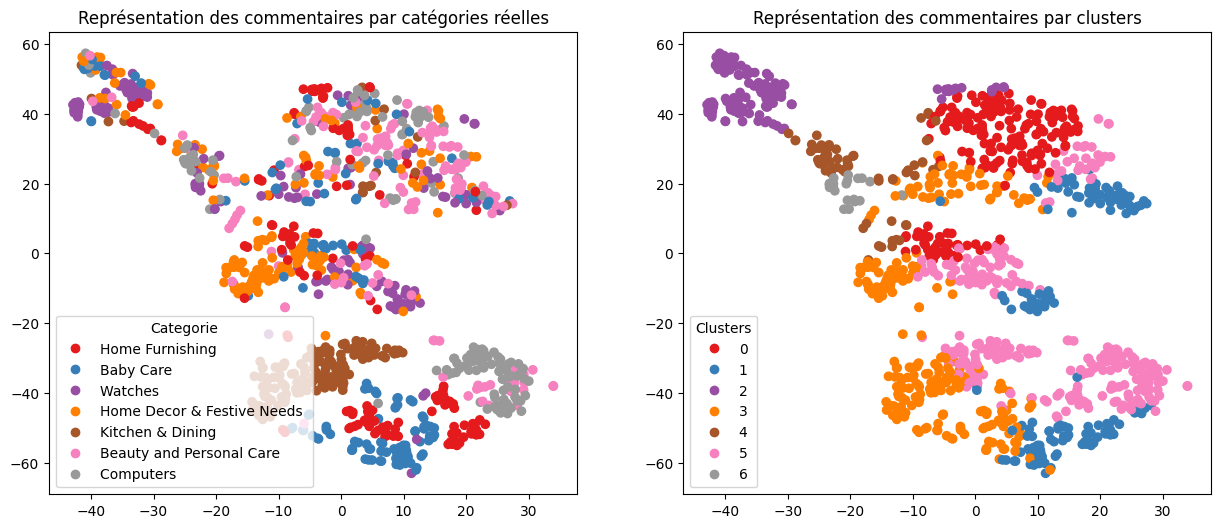

ARI :  0.0665


In [110]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [111]:
from transformers import RobertaTokenizer, TFRobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = TFRobertaModel.from_pretrained('roberta-base')
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [114]:
# Tokenize the text column
roberta_tokens = flipkart_filtered["text"].apply(lambda x: tokenizer(x, padding=True, truncation=True, return_tensors="tf"))

In [115]:
roberta_output = roberta_tokens.apply(lambda x: model(x))

In [121]:
roberta_output[0].keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [122]:
# for each tensor in the bert_tensors list, compute the embeddings with the BERT model
roberta_vectors = []
for output in roberta_output:
    roberta_vectors.append(output["pooler_output"].numpy().ravel())

In [124]:
# Unpack the list into a DataFrame
roberta_df = pd.DataFrame(roberta_vectors, index=flipkart_filtered.index, columns=[f"bert_{i}" for i in range(768)])

In [125]:
print("ROBERTA: ")
print("--------")
ARI, X_tsne, labels = ARI_fct(roberta_df)

ROBERTA: 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.1348 time :  30.0


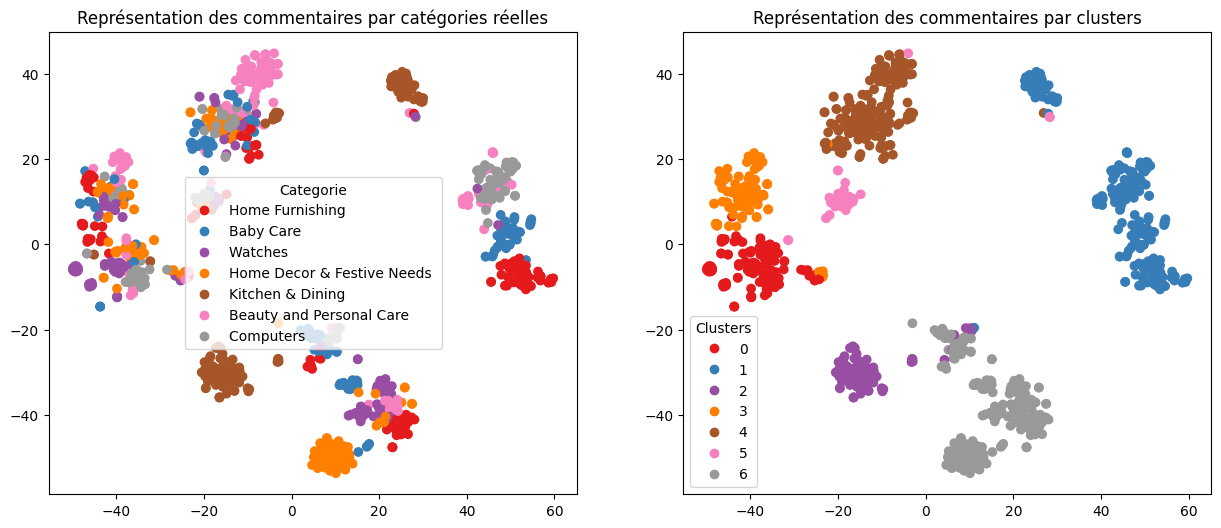

ARI :  0.1348


In [126]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE

Overview
The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 512 dimensional vector. 

In [ ]:
import tensorflow_hub as hub

In [ ]:
# Load the Universal Sentence Encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
# Encode the text column with the Universal Sentence Encoder
use_embeddings = flipkart_filtered["text"].apply(lambda x: embed([x]).numpy().ravel())

In [ ]:
# Unpack the list into a DataFrame
use_df = pd.DataFrame(use_embeddings.tolist(), index=flipkart_filtered.index, columns=[f"use_{i}" for i in range(512)])

In [ ]:
print("USE: ")
print("--------")
ARI, X_tsne, labels = ARI_fct(use_df)

USEE: 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.3503 time :  12.0


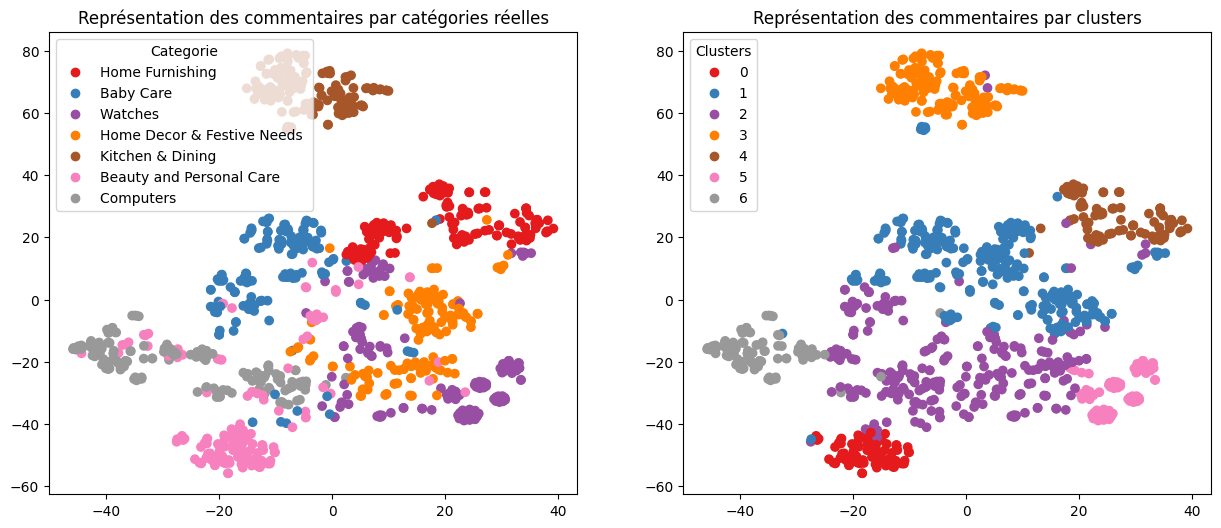

ARI :  0.3503


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)